## 0. Define function

In [1]:
import trimesh
import numpy as np

import os
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.spatial.transform import Rotation as R
import time
import pickle
import argparse
from utils import *
import matplotlib 
from matplotlib import pyplot as plt
from tqdm import tqdm
from deepVCP import DeepVCP
from deepVCP_loss import get_rigid_transform 

In [4]:
src_pts = trimesh.load('./meshes/bun000_v2.ply')

In [5]:
def cal_boundinbox_len(model):
    x_len = np.amax(model[:,0]) - np.amin(model[:,0])
    y_len = np.amax(model[:,1]) - np.amin(model[:,1])
    z_len = np.amax(model[:,2]) - np.amin(model[:,2])
    diag_len_bounding_box = np.sqrt(x_len * x_len + y_len * y_len + z_len * z_len)
    return diag_len_bounding_box

In [6]:
def generate_G_t(model, diag_len_bounding_box):
    theta_x = np.random.uniform(0, np.pi/5)
    theta_y = np.random.uniform(0, np.pi/5)
    theta_z = np.random.uniform(0, np.pi/5)
    
    # generate random translation
    translation_max = diag_len_bounding_box * 0.3
    translation_min = diag_len_bounding_box  * 0.3
    t = np.random.uniform(translation_min, translation_max, (3, 1))
    Rx = RotX(theta_x)
    Ry = RotY(theta_y)
    Rz = RotZ(theta_z)
    R = Rx @ Ry @ Rz
    target_points = R @ model.T + t
    return target_points, R, t

In [7]:
def display2(inputs, str = None):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    colors=['b','r']
    for idx, input in enumerate(inputs):
        ax.scatter(input[:,0], input[:,1], -input[:,2], c=colors[idx], marker='.', s=1)
    if str is not None:
        plt.title(str)
    plt.show()

In [46]:
def calculate_mse(img1, img2):
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    return  mse

In [41]:
def build_trans_matrix(R, t):
    trans_matrix = np.zeros(shape = (4, 4))
    trans_matrix[:3, :3] = R
    trans_matrix[:3, 3] = t.flatten()
    trans_matrix[3, 3] = 1
    return trans_matrix

## 1. Visualise test result

In [29]:
src = src_pts.sample(10000)
boundingbox_len = cal_boundinbox_len(src)
targets, R, t = generate_G_t(src, boundingbox_len)

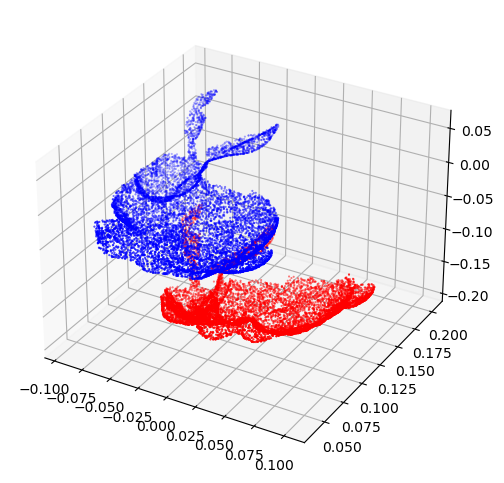

In [30]:
display2([src, targets.T])

In [31]:
R_prior = torch.from_numpy(R).cuda()#.unsqueeze(0)
corruption = torch.FloatTensor(1, 3, 3).uniform_(0.7, 1.4).cuda()
R_prior = R_prior*corruption
t_init =  torch.randn((1, 3)).cuda()

In [32]:
model = DeepVCP(use_normal=False).cuda()
model.load_state_dict(torch.load('epoch_19_model.pt', map_location='cuda'))

<All keys matched successfully>

In [33]:
src_xyz = torch.from_numpy(src.T).unsqueeze(0).cuda()
target_xyz = torch.from_numpy(targets).unsqueeze(0).cuda()
model.eval()
with torch.no_grad():
    src_keypts, target_vcp = model(src_xyz, target_xyz, R_prior, t_init)

feature extraction time:  9.899838924407959
src_keypts_idx_unsqueezed:  torch.Size([1, 3, 64])
src_keypts:  torch.Size([1, 64, 3])
Grouping keypoints time:  0.026909828186035156
B:  1
K_topk:  64
nsample:  32
num_feat:  32
get_cat_feat_src time:  0.0
tgt_pts_xyz:  torch.Size([1, 10000, 3])
ref_pts:  torch.Size([1, 10000, 3])
dist_normalize:  torch.Size([1, 32, 13824])
feat_weight_map:  torch.Size([1, 32, 32, 13824])
idx_1_mask:  tensor([[0]])
idx_1_mask_flatten:  tensor([0])
idx_2_mask:  tensor([2069, 8687, 6360,  ..., 4353, 4460, 6651], device='cuda:0')
get_cat_feat_tgt time:  0.10963273048400879


In [34]:
R_pre, t_pre = get_rigid_transform(src_keypts.permute(0,2,1).float(), target_vcp.permute(0,2,1).float())

In [35]:
src_t = torch.matmul(R_pre, src_xyz.float()) + t_pre
src_t = src_t.permute(0,2,1).cpu().numpy()[0].astype(np.float64)
z = np.array(targets.T)
org = (src_xyz[0].T @ R_prior).cpu().numpy()[0]

c:\Users\bingwang\.conda\envs\3D2\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Text(0.5, 1.0, 'DeepVCP result')

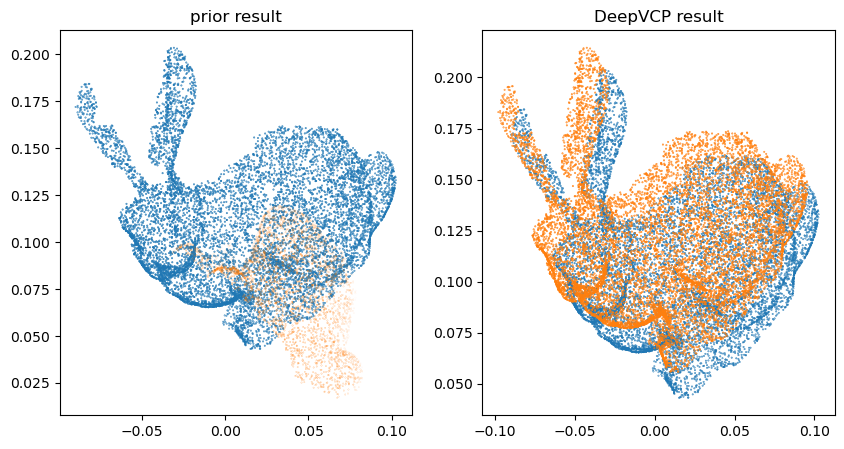

In [36]:
plt.figure(figsize=(10.0, 5.0))
plt.subplot(1, 2, 1)
plt.scatter(z[:,0], z[:,1], z[:,2])
plt.scatter(org[:,0], org[:,1], org[:,2])
plt.title('prior result')

plt.subplot(1, 2, 2)
plt.scatter(z[:,0], z[:,1], z[:,2])
plt.scatter(src_t[:,0], src_t[:,1], src_t[:,2])
plt.title('DeepVCP result')


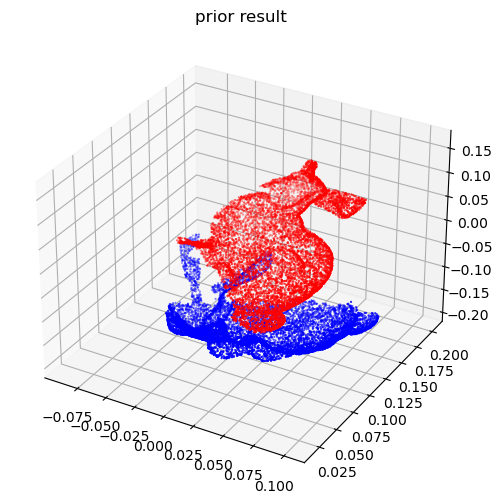

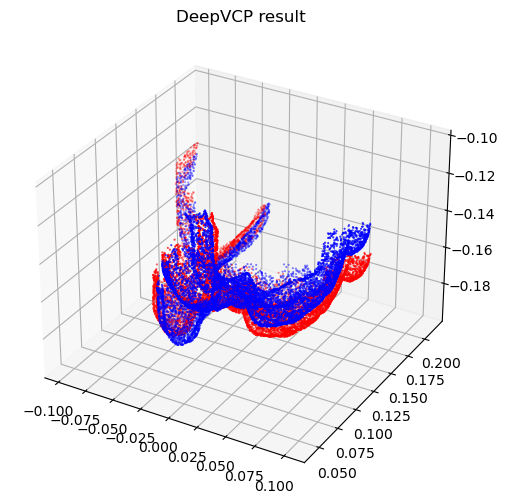

In [37]:
display2([z, org], str = 'prior result')
display2([z, src_t], str = 'DeepVCP result')

In [47]:
trans_true = build_trans_matrix(R, t)
trans_pred = build_trans_matrix(R_pre.cpu().numpy(), t_pre.cpu().numpy())
print('MSE error:', calculate_mse(trans_true, trans_pred))

MSE error: 0.0025287697


## 2. Compare with ICP

## 3. Add gaussian noise

In [49]:
def add_noise(model, noise_rate):
    x_len = np.amax(model[:,0]) - np.amin(model[:,0])
    y_len = np.amax(model[:,1]) - np.amin(model[:,1])
    z_len = np.amax(model[:,2]) - np.amin(model[:,2])
    diag_len_bounding_box = np.sqrt(x_len * x_len + y_len * y_len + z_len * z_len)
    # Add noise
    std = noise_rate * diag_len_bounding_box
    noise_model = model + np.random.normal(0, std, model.shape)
    return noise_model

## 4. Global registration